In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from umap import UMAP

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load inhibitor activity dataset

In [2]:
X_train_all = pd.read_csv('datasets/X_train.csv', header = 0, index_col = 0)
y_train_all = pd.read_csv('datasets/y_train.csv', header = 0, index_col = 0)

X_test = pd.read_csv('datasets/X_test.csv', header = 0, index_col = 0)
y_test = pd.read_csv('datasets/y_test.csv', header = 0, index_col = 0)

### Check feature format and distribution
Inputs are all binary features

In [3]:
print(X_train_all.shape)
X_train_all.head(2)

(6171, 531)


,KRFP1,KRFP2,KRFP14,KRFP16,KRFP17,KRFP20,KRFP33,KRFP45,KRFP67,KRFP72,...,KRFP4820,KRFP4823,KRFP4826,KRFP4827,KRFP4829,KRFP4833,KRFP4835,KRFP4843,KRFP4853,KRFP4856
Compound1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Compound2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
y_train_all.value_counts()

class
1        4556
0        1615
Name: count, dtype: int64

### Visualize the data distribution with UMAP
Use `metric = hamming` for binary data. No need to standardize the data

In [5]:
umap = UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.25, random_state = 4649,
            metric = 'hamming').fit(X_train_all)
X_train_umap = umap.transform(X_train_all)

C:\Users\kppt\anaconda3\lib\site-packages\umap\umap_.py:1879: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
C:\Users\kppt\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
X_train_umap_with_result = pd.DataFrame(X_train_umap[:, :2], columns = ['UMAP1', 'UMAP2'], index = X_train_all.index)
X_train_umap_with_result['Activity'] = ''

X_train_umap_with_result.loc[y_train_all['class'] == 0, 'Activity'] = 'None'
X_train_umap_with_result.loc[y_train_all['class'] == 1, 'Activity'] = 'Inhibitor'

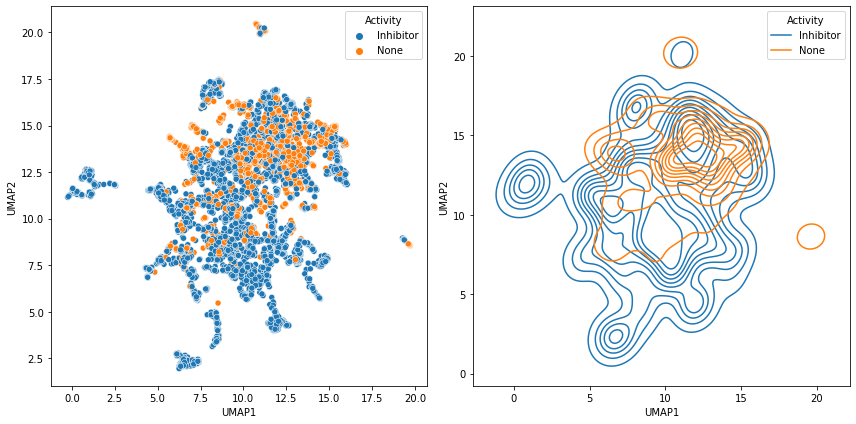

In [7]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1); sns.scatterplot(data = X_train_umap_with_result, x = 'UMAP1', y = 'UMAP2', hue = 'Activity')
plt.subplot(1, 2, 2); sns.kdeplot(data = X_train_umap_with_result, x = 'UMAP1', y = 'UMAP2', hue = 'Activity')
plt.tight_layout()
plt.show()

## Split the training dataset into training and validation (for early stopping)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all['class'], test_size = 0.25, 
                                                  stratify = y_train_all['class'],
                                                  shuffle = True, random_state = 4649)

## Load PyTorch library for artificial neural network development
Use the following code if your computer doesn't have a GPU

Go to [PyTorch website](https://pytorch.org/get-started/locally/) if you have CUDA-capable GPU

In [9]:
# !pip install torch torchvision torchaudio tensorboard torcheval

### `torcheval` library contains many performance metrics

In [10]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

from torcheval.metrics import BinaryAccuracy, BinaryAUPRC, BinaryAUROC, BinaryF1Score

acc_metric = BinaryAccuracy(threshold = 0.5)
f1_metric = BinaryF1Score(threshold = 0.5)
ap_metric = BinaryAUPRC()
auc_metric = BinaryAUROC()

batch_size = 64

## Define how the data will be loaded into the model
For deep learning, the whole dataset is usually too large to be loaded into the memory. These steps will load the data as needed on the fly.

Notice how we need to transform `array` that we are used to into `tensor` (essentially multidimensional array)

Here, because we have loaded the entire dataframe, this process will involve only extracting the corresponding rows

In [11]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values).type(torch.FloatTensor)
        self.y = torch.tensor(y.values).type(torch.LongTensor)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [12]:
train_dataloader = DataLoader(MyDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(MyDataset(X_val, y_val), batch_size = batch_size, shuffle = True)

## Detect whether our computer has a GPU
GPU and CPU utilize separate memory, so the data and model has to be sent to the corresponding `device`

In [13]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using {device} device")

Using cuda device


## Define our artificial neural network model
This is a two-layer feedforward network, similar to the diagram we saw in class. The output is the positive class score (which will be transform into probability later)

In [14]:
input_size = X_train.shape[1]

class ClassificationNetwork(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], 1)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        score = self.fc3(x)

        return score

In [30]:
model = ClassificationNetwork(hidden_layers = (128, 16))
model.eval()

ClassificationNetwork(
  (fc1): Linear(in_features=531, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

## Define the training routine
1. During the **train step**, loss on the training set is used to update model's weights
2. During the **validate step**, loss and performance scores on the validation set were used to keep track of the progress

In [15]:
def train_step(dataloader, model, loss_fn, optimizer, verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0.0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).float()

        # compute prediction loss to keep track of model performance
        pred = torch.flatten(model(X))
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # backpropagation to update model's weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_loss /= num_batches
    
    if verbose:
        print(f"Training loss: {train_loss:>8f}")
        
    return train_loss

In [16]:
def validate_step(dataloader, model, loss_fn, verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0.0

    all_preds = []
    all_ys = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).float()
            pred = torch.flatten(model(X))
            val_loss += loss_fn(pred, y).item()

            all_preds.append(pred)
            all_ys.append(y)
            
    val_loss /= num_batches

    all_preds = torch.cat(all_preds, dim = 0)
    all_ys = torch.cat(all_ys, dim = 0)
    
    acc_metric.update(all_preds, all_ys)
    accuracy = acc_metric.compute()

    auc_metric.update(all_preds, all_ys)
    auc = auc_metric.compute()

    ap_metric.update(all_preds, all_ys)
    ap = ap_metric.compute()

    f1_metric.update(all_preds, all_ys)
    f1 = f1_metric.compute()

    if verbose:
        print(f"  Validation acc: {(accuracy * 100):>0.1f}%, loss: {val_loss:>8f}")

    acc_metric.reset()
    auc_metric.reset()
    ap_metric.reset()
    f1_metric.reset()
    
    return val_loss, accuracy, auc, ap, f1

### Define protocol for terminating the training if loss does not improve on the validation set
`patience` defines how many training epochs to tolerate

In [17]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            
            if self.counter >= self.patience:
                return True
        
        return False

### Putting the pieces together
Use `ReduceLROnPlateau` to adaptively reduce the learning rate (slow down the weight update) when the loss stop improving

Use `SummaryWriter` to save the training and validation progress to visualize later (save to `log_dir/run_name`)

`BCEWithLogitsLoss` is the binary cross entropy loss, which measure the error in probability

`Adam` is a popular optimizer for neural network model's weights

In [18]:
def full_loop(epochs, hidden_layers, init_lr, log_dir, run_name, train_verbose = True, val_verbose = True):
    nn_model = ClassificationNetwork(hidden_layers).to(device)
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr = init_lr)
    early_stopping = EarlyStopping()
    log_writer = SummaryWriter(log_dir = log_dir + '/' + run_name)
    
    for epoch in range(epochs):
        if (epoch + 1) % 20 == 1:
            print('Epoch', epoch + 1, '-------------------------------')
        
        train_loss = train_step(train_dataloader, nn_model, loss, optimizer, train_verbose)
        val_loss, val_accuracy, val_auc, val_ap, val_f1 = validate_step(val_dataloader, nn_model, loss, val_verbose)

        log_writer.add_scalar('Loss/train', train_loss, epoch)
        log_writer.add_scalar('Loss/val', val_loss, epoch)
        log_writer.add_scalar('Performance/Accuracy', val_accuracy, epoch)
        log_writer.add_scalar('Performance/AUROC', val_auc, epoch)
        log_writer.add_scalar('Performance/AvgPrecision', val_ap, epoch)
        log_writer.add_scalar('Performance/F1', val_f1, epoch)

        if early_stopping.early_stop(val_loss):
            print('EarlyStopping: No loss improvement on the validation set')
            break
            
    log_writer.flush()
    
    if epoch + 1 == epochs:
        print('End of training due to epoch limit')
    
    return nn_model

In [27]:
trained_model_1 = full_loop(100, (128, 16), 1e-3, 'classification', 'ffw-128-16')

Epoch 1 -------------------------------
Training loss: 0.479665
  Validation acc: 79.5%, loss: 0.406061
Training loss: 0.354687
  Validation acc: 82.5%, loss: 0.389846
Training loss: 0.307250
  Validation acc: 83.0%, loss: 0.343417
Training loss: 0.265747
  Validation acc: 83.7%, loss: 0.325626
Training loss: 0.222951
  Validation acc: 85.2%, loss: 0.307204
Training loss: 0.188663
  Validation acc: 86.6%, loss: 0.289942
Training loss: 0.159789
  Validation acc: 88.3%, loss: 0.284361
Training loss: 0.126474
  Validation acc: 87.4%, loss: 0.314280
Training loss: 0.107463
  Validation acc: 88.5%, loss: 0.292005
Training loss: 0.089894
  Validation acc: 88.7%, loss: 0.297538
Training loss: 0.081137
  Validation acc: 88.4%, loss: 0.326325
Training loss: 0.065794
  Validation acc: 89.2%, loss: 0.334763
EarlyStopping: No loss improvement on the validation set


In [28]:
trained_model_2 = full_loop(100, (256, 32), 5e-4, 'classification', 'ffw-256-32')

Epoch 1 -------------------------------
Training loss: 0.499513
  Validation acc: 79.7%, loss: 0.432660
Training loss: 0.371702
  Validation acc: 81.2%, loss: 0.378473
Training loss: 0.322383
  Validation acc: 82.5%, loss: 0.366081
Training loss: 0.282395
  Validation acc: 84.5%, loss: 0.328407
Training loss: 0.239612
  Validation acc: 85.7%, loss: 0.319143
Training loss: 0.207396
  Validation acc: 85.9%, loss: 0.298534
Training loss: 0.173927
  Validation acc: 87.0%, loss: 0.297232
Training loss: 0.147046
  Validation acc: 87.4%, loss: 0.284370
Training loss: 0.125534
  Validation acc: 88.5%, loss: 0.286429
Training loss: 0.106348
  Validation acc: 88.7%, loss: 0.293998
Training loss: 0.090722
  Validation acc: 89.2%, loss: 0.296678
Training loss: 0.078471
  Validation acc: 88.7%, loss: 0.290350
Training loss: 0.067967
  Validation acc: 89.0%, loss: 0.305908
EarlyStopping: No loss improvement on the validation set


In [29]:
trained_model_3 = full_loop(100, (512, 64), 1e-4, 'classification', 'ffw-512-64')

Epoch 1 -------------------------------
Training loss: 0.584878
  Validation acc: 76.2%, loss: 0.509506
Training loss: 0.460748
  Validation acc: 79.8%, loss: 0.470697
Training loss: 0.402949
  Validation acc: 80.8%, loss: 0.411713
Training loss: 0.365945
  Validation acc: 81.8%, loss: 0.386819
Training loss: 0.344232
  Validation acc: 82.3%, loss: 0.374656
Training loss: 0.322060
  Validation acc: 81.9%, loss: 0.362862
Training loss: 0.305281
  Validation acc: 83.5%, loss: 0.353158
Training loss: 0.284705
  Validation acc: 83.7%, loss: 0.339527
Training loss: 0.269889
  Validation acc: 83.7%, loss: 0.343164
Training loss: 0.254201
  Validation acc: 84.4%, loss: 0.323451
Training loss: 0.237234
  Validation acc: 85.0%, loss: 0.312993
Training loss: 0.223436
  Validation acc: 84.9%, loss: 0.306140
Training loss: 0.208048
  Validation acc: 86.1%, loss: 0.312006
Training loss: 0.193897
  Validation acc: 86.9%, loss: 0.318902
Training loss: 0.183713
  Validation acc: 86.6%, loss: 0.290290


## Visualize the training progress via `tensorboard`

In [26]:
%load_ext tensorboard
%tensorboard --logdir classification

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Make prediction
The code is long because we need to cast the data as `tensor`, send them to `gpu`, get them back, and transform back to `array`

We also perform `torch.sigmoid` to transform raw scores (linear) into probabilities (logistic)

In [33]:
test_pred_1 = torch.sigmoid(trained_model_1(torch.tensor(X_test.values).type(torch.FloatTensor).to(device))).cpu().detach().numpy()
test_pred_2 = torch.sigmoid(trained_model_2(torch.tensor(X_test.values).type(torch.FloatTensor).to(device))).cpu().detach().numpy()
test_pred_3 = torch.sigmoid(trained_model_3(torch.tensor(X_test.values).type(torch.FloatTensor).to(device))).cpu().detach().numpy()

In [34]:
test_pred_1

array([[0.95461273],
       [0.6338525 ],
       [0.99991715],
       ...,
       [0.99984145],
       [0.9840714 ],
       [0.9996958 ]], dtype=float32)

In [37]:
print(classification_report(y_test['class'], test_pred_1 > 0.5))

              precision    recall  f1-score   support

           0       0.85      0.75      0.79       391
           1       0.92      0.95      0.94      1152

    accuracy                           0.90      1543
   macro avg       0.88      0.85      0.87      1543
weighted avg       0.90      0.90      0.90      1543



## Extract the embedding from `trained_model_1`
We can use either the first or the second layer

This is also called the `activation` of the model at those layers

In [81]:
trained_model_2.eval()

ClassificationNetwork(
  (fc1): Linear(in_features=531, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [86]:
activation = {}

def get_activation(name):
    def hook(model, inputs, outputs):
        activation[name] = outputs.detach().cpu()
        
    return hook

trained_model_2.fc1.register_forward_hook(get_activation('fc1'))
trained_model_2.fc2.register_forward_hook(get_activation('fc2'))
_ = trained_model_2(torch.tensor(X_train_all.values).type(torch.FloatTensor).to(device))

In [87]:
print(X_train_all.shape)
print(activation['fc1'].shape)
print(activation['fc2'].shape)

(6171, 531)
torch.Size([6171, 256])
torch.Size([6171, 32])


## Visualize embedding distribution with UMAP
Switched back to `euclidean` distance

In [88]:
fc1_umap = UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.25, random_state = 4649,
                metric = 'euclidean').fit_transform(activation['fc1'])
fc2_umap = UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.25, random_state = 4649,
                metric = 'euclidean').fit_transform(activation['fc2'])

C:\Users\kppt\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\kppt\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [89]:
fc1_umap_with_result = pd.DataFrame(fc1_umap, columns = ['UMAP1', 'UMAP2'], index = X_train_all.index)
fc1_umap_with_result['Activity'] = ''
fc1_umap_with_result.loc[y_train_all['class'] == 0, 'Activity'] = 'None'
fc1_umap_with_result.loc[y_train_all['class'] == 1, 'Activity'] = 'Inhibitor'

fc2_umap_with_result = pd.DataFrame(fc2_umap, columns = ['UMAP1', 'UMAP2'], index = X_train_all.index)
fc2_umap_with_result['Activity'] = ''
fc2_umap_with_result.loc[y_train_all['class'] == 0, 'Activity'] = 'None'
fc2_umap_with_result.loc[y_train_all['class'] == 1, 'Activity'] = 'Inhibitor'

### Embedding from the first layer still cannot clearly distinguish the classes

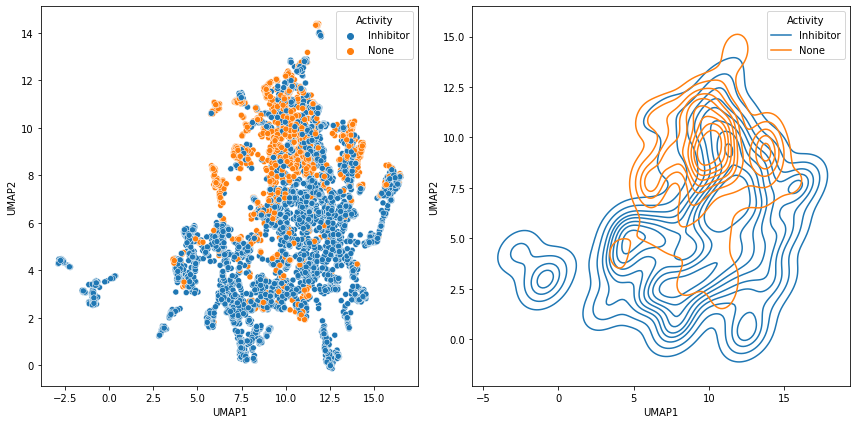

In [90]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1); sns.scatterplot(data = fc1_umap_with_result, x = 'UMAP1', y = 'UMAP2', hue = 'Activity')
plt.subplot(1, 2, 2); sns.kdeplot(data = fc1_umap_with_result, x = 'UMAP1', y = 'UMAP2', hue = 'Activity')
plt.tight_layout()
plt.show()

### Embedding from the second layer can distinguish between inhibitors and non-inhibitors

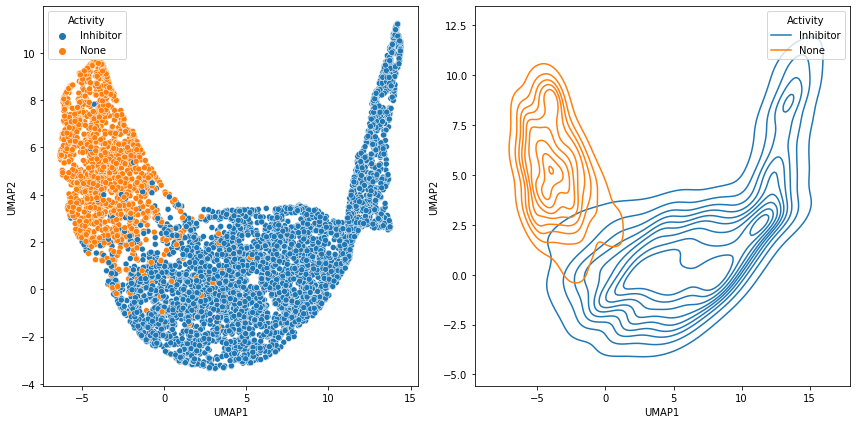

In [91]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1); sns.scatterplot(data = fc2_umap_with_result, x = 'UMAP1', y = 'UMAP2', hue = 'Activity')
plt.subplot(1, 2, 2); sns.kdeplot(data = fc2_umap_with_result, x = 'UMAP1', y = 'UMAP2', hue = 'Activity')
plt.tight_layout()
plt.show()